#Explainability

Import the libraries necessary to analize data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
import shap
from lime.lime_tabular import LimeTabularExplainer
from aix360.metrics import faithfulness_metric, monotonicity_metric
from imblearn.under_sampling import RandomUnderSampler


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
dt = pd.read_csv('../Task1/df_after_dp.csv', parse_dates=['date'])
df = dt.copy(deep = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

The calssification task requires to predict whether in the incident there were killed people. Hence we create the binary attribute involve_killing

In [3]:
df['involve_killing'] = np.where(df['n_killed'] > 0, 1, 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       166664 non-null  datetime64[ns]
 1   state                      166664 non-null  object        
 2   city_or_county             166664 non-null  object        
 3   latitude                   166664 non-null  float64       
 4   longitude                  166664 non-null  float64       
 5   congressional_district     166664 non-null  int64         
 6   avg_age_participants       166664 non-null  float64       
 7   n_participants_child       166664 non-null  int64         
 8   n_participants_teen        166664 non-null  int64         
 9   n_females                  166664 non-null  float64       
 10  n_killed                   166664 non-null  float64       
 11  n_injured                  166664 non-null  float64 

## Discretize categorical values

We discretize the categorical values to use them in the classification task

In [4]:
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [5]:
to_discretize = ['date', 'state', 'city_or_county', 'party']
df = discretize_data(df, to_discretize)

In [6]:
df.drop(columns=['date', 'state', 'city_or_county', 'party', 'incident_characteristics1'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166664 entries, 0 to 166663
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   latitude                   166664 non-null  float64
 1   longitude                  166664 non-null  float64
 2   congressional_district     166664 non-null  int64  
 3   avg_age_participants       166664 non-null  float64
 4   n_participants_child       166664 non-null  int64  
 5   n_participants_teen        166664 non-null  int64  
 6   n_females                  166664 non-null  float64
 7   n_killed                   166664 non-null  float64
 8   n_injured                  166664 non-null  float64
 9   n_arrested                 166664 non-null  float64
 10  n_unharmed                 166664 non-null  float64
 11  n_participants             166664 non-null  float64
 12  povertyPercentage          166664 non-null  float64
 13  candidatevotes             16

In [7]:

df.drop(columns=['latitude', 'longitude', 'n_killed', 'n_injured', 'n_unharmed', 'candidatevotes', 'totalvotes', 'incident_gravity', 'females_rate',
       'minor_rate', 'arrested_rate', 'survival_rate',  'killed_rate', 'injured_rate',
       'killed_disp_per_district', 'injured_disp_per_district',
       'part_disp_per_district', 'winning_party_percentage'], axis=1,inplace=True)


In [8]:
label = df.pop('involve_killing')

We partitioned the dataset into training, validation, and test sets using a 70/15/15 split. Additionally, by merging the training and validation sets, we established a development set, comprising 85% of the data, since certain models do not necessitate validation.

In [9]:
X_trvl, X_test, y_trvl, y_test = train_test_split(df, label, test_size=0.15,random_state=10, stratify=label)
X_train, X_val, y_train, y_val = train_test_split(X_trvl, y_trvl, test_size=0.18,random_state=10, stratify=y_trvl)

In [10]:
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=15)
X_trvl_undersample, y_trvl_undersample = undersample.fit_resample(X_trvl, y_trvl)
print(y_trvl_undersample.value_counts(True))

involve_killing
0    0.5
1    0.5
Name: proportion, dtype: float64


Used to summarize the data to only "K" centroids, since executing shap against the whole dataset is prohibitive computationally

In [11]:
#TODO change K
K = 10
background_summary = shap.kmeans(X_trvl_undersample, K) #background data

Lime intialization

In [12]:
explainer_lime = LimeTabularExplainer(np.array(X_trvl_undersample), feature_names=X_train.columns, class_names=["No-killing", "Killing"],training_labels=y_trvl_undersample,mode="classification",verbose=True)

Explainability models metrics

In [13]:
def explain_lime(explaination,index,model):
    le = explaination.local_exp[1]

    m = explaination.as_map()
    x = X_test.values[index]
    coefs = np.zeros(x.shape[0])

    for v in le:
        coefs[v[0]] = v[1]


    base = np.zeros(x.shape[0])

    print("Faithfulness: ", faithfulness_metric(model, x, coefs, base))
    print("Monotonity: ", monotonicity_metric(model, x,coefs, base))


In [14]:
def explain_shap_metrics(shap_values,model,index):
    predicted_class = model.predict(X_test.values[index].reshape(1,-1))[0]
    x = X_test.values[index]
    base = np.zeros(x.shape[0])
    print("Faithfulness: ", faithfulness_metric(model, x, shap_values[predicted_class][0], base))
    print("Monotonity: ", monotonicity_metric(model, x, shap_values[predicted_class][0], base))

## Random Forest

import libraries for random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
rd_fr = RandomForestClassifier(n_estimators=128, 
                             criterion='gini',
                             max_features="log2",
                             max_depth=15, 
                             min_samples_leaf=4,
                             bootstrap=False) 

We run the classifier

In [16]:
rd_fr.fit(X_trvl_undersample.values,y_trvl_undersample.values)

RandomForestClassifier(bootstrap=False, max_depth=15, max_features='log2',
                       min_samples_leaf=4, n_estimators=128)

Explain random forest with shap

In [17]:
# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(rd_fr)
explain_tree = explainer(X_test[0:20])
shap_values_tree = explainer.shap_values(X_test[0:20])
shap_interaction_values_tree = explainer.shap_interaction_values(X_test.iloc[0:20]) 

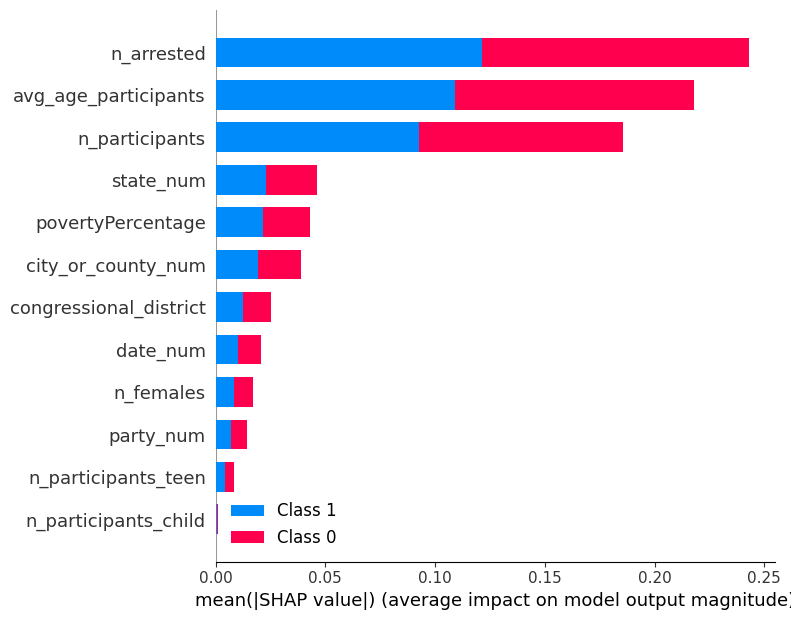

In [18]:
shap.summary_plot(shap_values_tree, X_test[0:20])

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_tree[0], X_test[0:20])

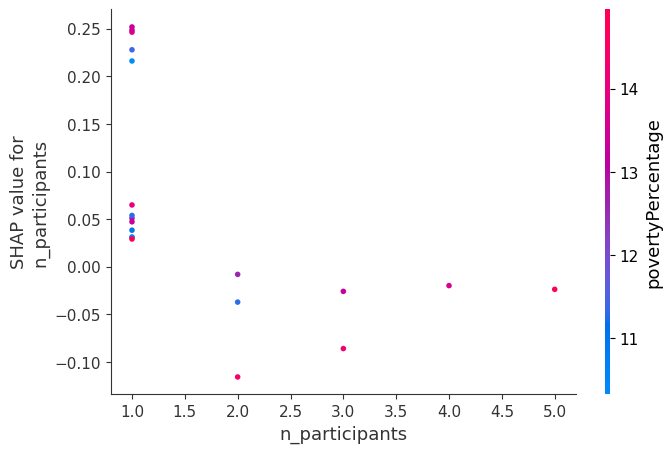

In [20]:
shap.dependence_plot("n_participants", shap_values_tree[0], X_test[0:20])

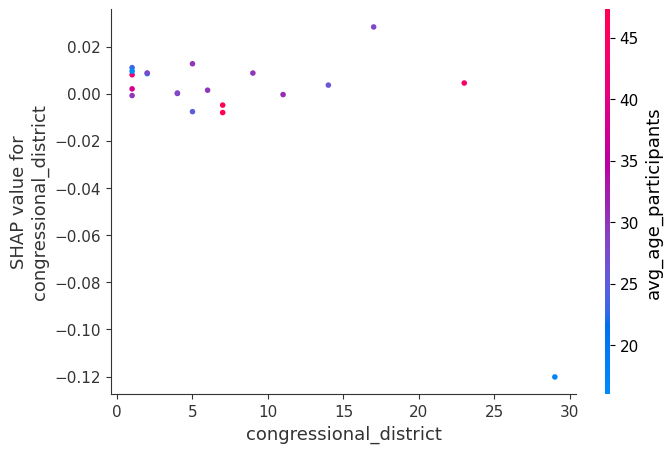

In [21]:
shap.dependence_plot("congressional_district", shap_values_tree[0], X_test[0:20])

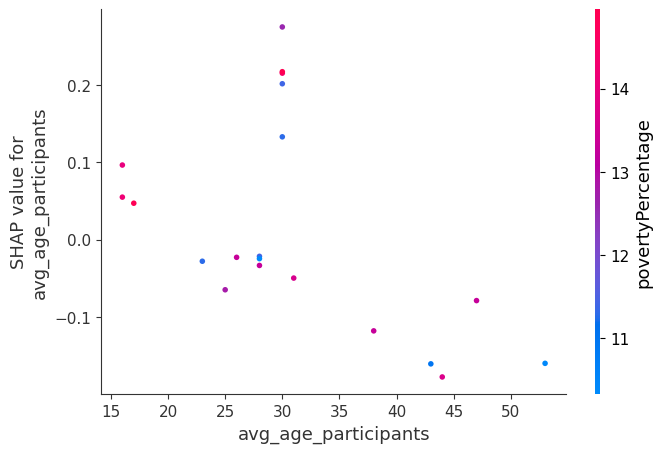

In [22]:
shap.dependence_plot("avg_age_participants", shap_values_tree[0], X_test[0:20])

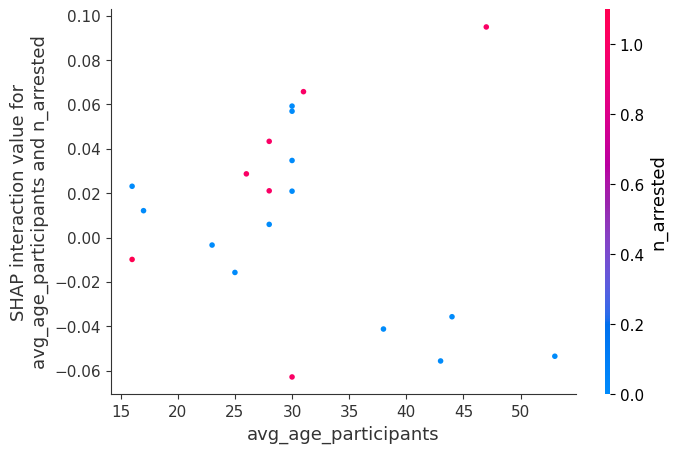

In [23]:
shap.dependence_plot(
    ("avg_age_participants", "n_arrested"),
    shap_interaction_values_tree[0], X_test.iloc[0:20]
)

LABEL: 0
Predicted LABEL: [1]
ROW: 0


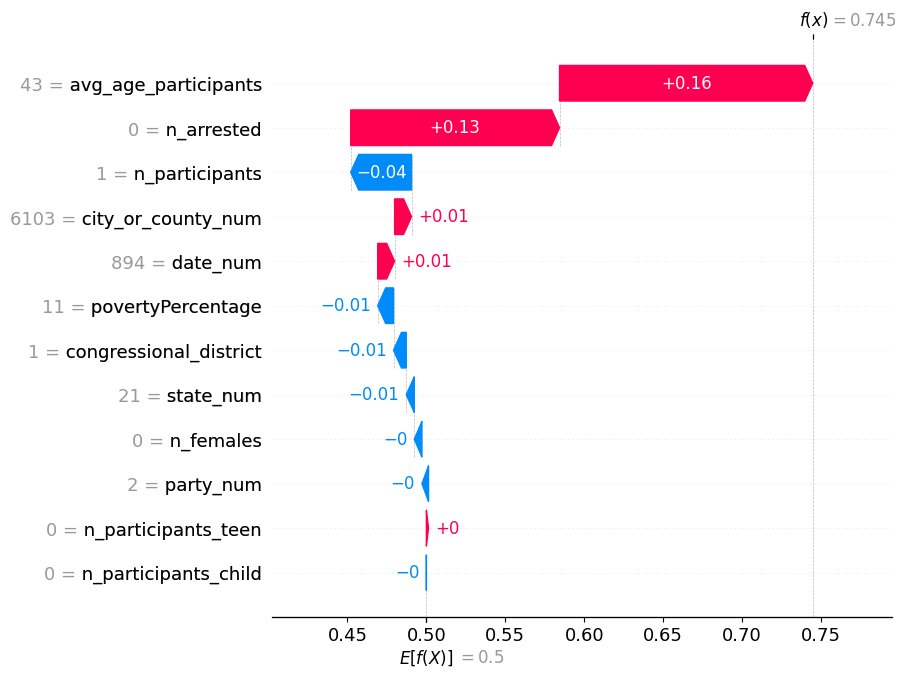

In [24]:
# visualize the first prediction's explanation
print("LABEL:",y_test.iloc[0])
predicted_class = rd_fr.predict(X_test.values[0].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("ROW:",0)

id_to_explain = 0                  
output_to_explain = 1
shap.plots.waterfall(explain_tree[id_to_explain,:,output_to_explain],max_display=15)



For this instance we can see that 6 features (n_participants_child,n_participants_teen,n_females,party_num) are not helpful to classify this row with index 0.
The first thing to observe is the fact the mean prediction across all rows is 0.5, this is the result of using undersampling.
1) avg_age_participants = 43, increases the chances of having the label equal to 1 by 17%. This means that this is the most important feature for this specific instance. If we check the n_killed persons from the original dataset, we can see how for half of the records there's atleast a person killed when the average age is 43.
2) n_arrested = 0, increases the chances of having the label equal to 1 by 13%.  

1) n_females = 0, reduces the chances of having iskilling equal to 1 (1%)
2) povertyPercentage = 9.8%, lower than the mean value (12.0%) but still impactful to classify the row, it increases the probability of having iskilling equal to 1 by 1%
3) winning_party_percentage = 0.818, that further increases the percentage by 2% towards the class 1 for isKilling
4) n_unharmed = 1, decreases the probabilty of having a dead person by 3%. This is understandable since the n_participants drops to 1, knowing that the other one is not dead and the fact that n_killed is linearly calculable from the other features
5) Congressional_district = 7, moves the probability towards 1 by 4%. Since the cities with this congressional district have high rate of homicides (Probable caused by the fact that ???)
6) avg_age_participants = 21, increases the probability by 5%, the number of records that have at least a person killed is 25% (1/4 of records). In this way we can see why it pushes the probability towards the value "1".
7) n_participants = 2, increases by 6% the probability of having a killed person. This because the number of records with 2 participants and having a dead person are 27%.
8) n_injured = 0, since isKilling can be linearly calculated thanks to this value, having it at 0 boosts the classifier towards the iskilling = 1.
Those combined proabibilities gives probability 0.41 that the istance will be classified as 1 and 0.59 to be classified as 0.

In [47]:
dt[dt["avg_age_participants"] == 43]["n_killed"].value_counts()

n_killed
0.0    764
1.0    419
2.0     52
3.0     11
4.0      3
Name: count, dtype: int64

In [48]:
dt[dt["n_arrested"] == 0]["n_killed"].value_counts()

n_killed
0.0     74279
1.0     27538
2.0      3018
3.0       368
4.0        80
5.0        20
6.0         6
8.0         2
9.0         2
7.0         1
10.0        1
Name: count, dtype: int64

In [26]:
X_test.iloc[0]

congressional_district       1.0
avg_age_participants        43.0
n_participants_child         0.0
n_participants_teen          0.0
n_females                    0.0
n_arrested                   0.0
n_participants               1.0
povertyPercentage           11.0
date_num                   894.0
state_num                   21.0
city_or_county_num        6103.0
party_num                    2.0
Name: 1816, dtype: float64

In [27]:
sorted(dt["state"].unique())[20]


'massachusetts'

In [28]:
(dt[dt["congressional_district"] == 7]["state"]).unique()

array(['indiana', 'pennsylvania', 'michigan', 'north carolina',
       'virginia', 'new york', 'missouri', 'texas', 'california',
       'illinois', 'washington', 'florida', 'georgia', 'massachusetts',
       'tennessee', 'new jersey', 'ohio', 'colorado', 'maryland',
       'arizona', 'minnesota', 'wisconsin', 'alabama', 'south carolina'],
      dtype=object)

In [29]:
mean_values = dt.groupby("congressional_district")["n_killed"].mean()
mean_values.sort_values(ascending=False)

congressional_district
45    0.833333
43    0.752381
40    0.731844
44    0.709877
37    0.660194
29    0.626398
34    0.590551
33    0.583535
30    0.563670
49    0.528571
32    0.518248
38    0.508475
42    0.494624
28    0.433604
50    0.431579
39    0.428571
41    0.421053
47    0.410256
36    0.407708
51    0.407643
31    0.398649
35    0.394279
48    0.391304
53    0.388889
46    0.347594
52    0.344444
14    0.327368
6     0.320077
18    0.319509
5     0.317697
21    0.316916
15    0.313587
20    0.310749
22    0.300654
24    0.300348
10    0.298190
12    0.291533
7     0.291526
13    0.291304
9     0.289639
8     0.288472
3     0.286661
4     0.285797
11    0.279478
23    0.277721
1     0.274052
2     0.271017
25    0.267474
19    0.248151
16    0.247820
0     0.246841
27    0.235122
26    0.217332
17    0.188413
Name: n_killed, dtype: float64

In [30]:
print(dt[dt["avg_age_participants"] == 21]["n_killed"].value_counts(True))


n_killed
0.0    0.732417
1.0    0.254813
2.0    0.010806
3.0    0.001572
4.0    0.000393
Name: proportion, dtype: float64


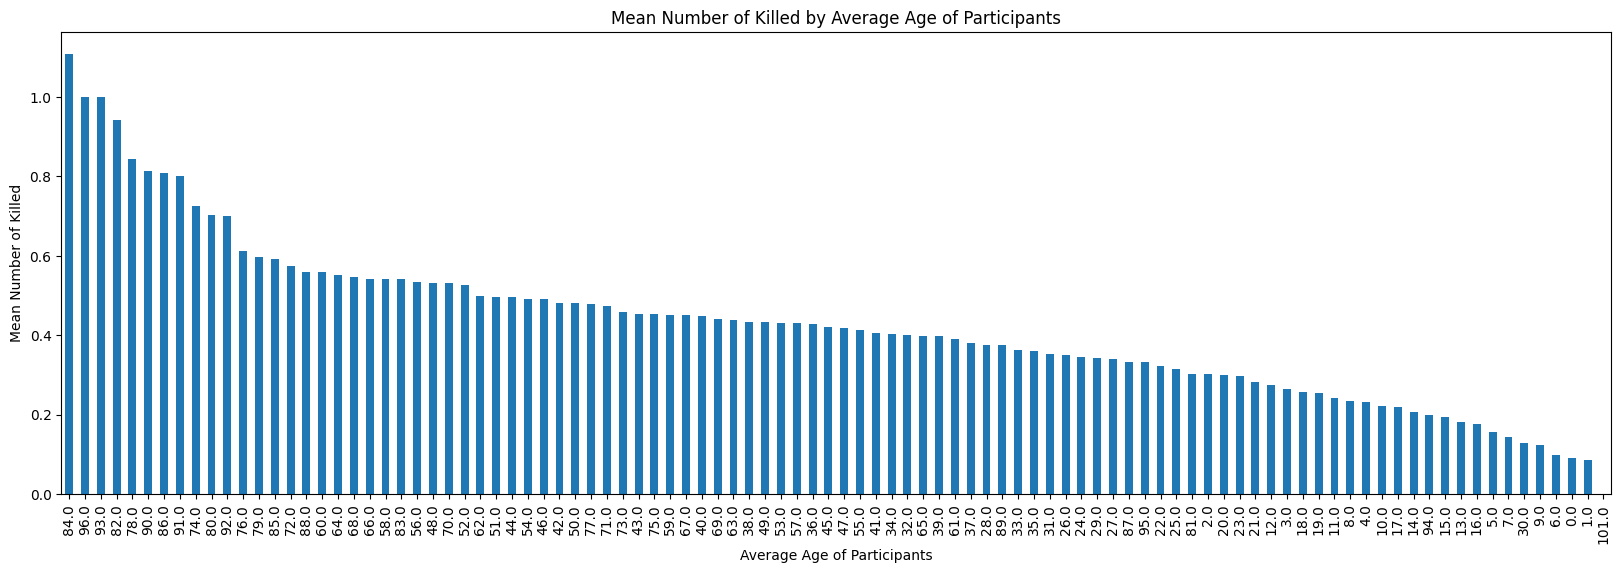

In [31]:

mean_values = dt.groupby("avg_age_participants")["n_killed"].mean()
mean_values_sorted = mean_values.sort_values(ascending=False)
# Plot the bar chart
mean_values_sorted.plot(kind='bar', figsize=(20, 6))
plt.title('Mean Number of Killed by Average Age of Participants')
plt.xlabel('Average Age of Participants')
plt.ylabel('Mean Number of Killed')
plt.show()

In [32]:
print(dt[dt["n_participants"] == 2]["n_killed"].mean())


0.36639077188120295


In [33]:
print(dt[dt["n_participants"] == 2]["n_killed"].value_counts(True))


n_killed
0.0    0.678270
1.0    0.277068
2.0    0.044661
Name: proportion, dtype: float64


In [34]:
explain_shap_metrics(shap_values_tree,rd_fr,0)

Faithfulness:  0.6324958935133341
Monotonity:  False


LABEL: 0
Predicted LABEL: [0]
ROW: 4


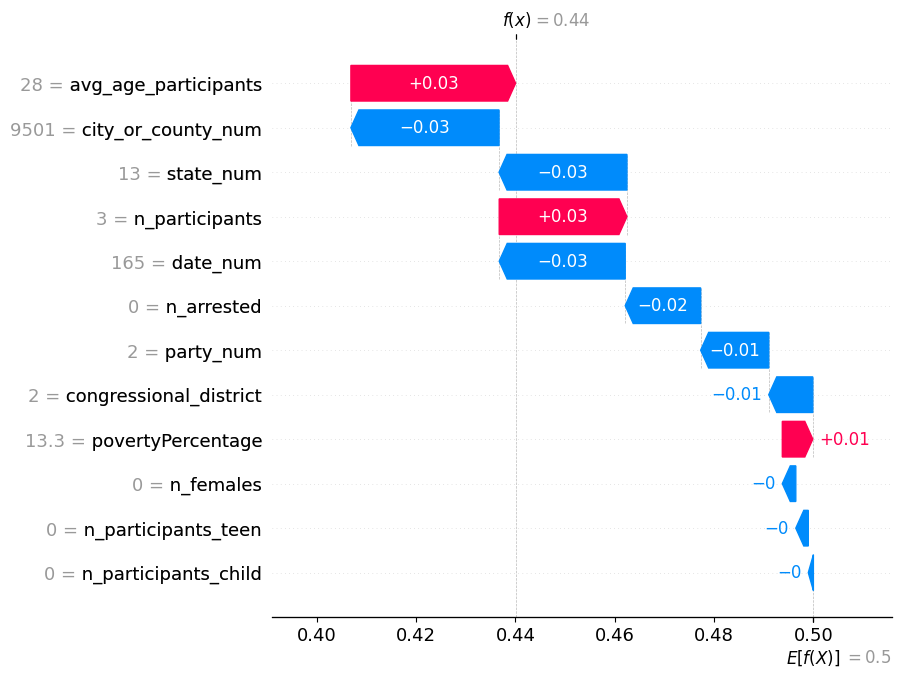

In [35]:
print("LABEL:",y_test.iloc[4])
predicted_class = rd_fr.predict(X_test.values[4].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("ROW:",4)
id_to_explain = 4
output_to_explain = 1
shap.plots.waterfall(explain_tree[id_to_explain,:,output_to_explain],max_display=15)


n_participants_child,n_participants_teen,date_num,state_num,city_or_county_num,party_num

In [36]:
dt[dt["povertyPercentage"] > 20]["state"]
(dt[dt["congressional_district"] == 7]["state"]).unique()

array(['indiana', 'pennsylvania', 'michigan', 'north carolina',
       'virginia', 'new york', 'missouri', 'texas', 'california',
       'illinois', 'washington', 'florida', 'georgia', 'massachusetts',
       'tennessee', 'new jersey', 'ohio', 'colorado', 'maryland',
       'arizona', 'minnesota', 'wisconsin', 'alabama', 'south carolina'],
      dtype=object)

In [37]:
explain_shap_metrics(shap_values_tree,rd_fr,4)

Faithfulness:  0.32444908586311044
Monotonity:  False


Lime explain

In [38]:
instance_to_explain = X_test.iloc[0]
print("LABEL:",y_test.iloc[0])

explanation_1 = explainer_lime.explain_instance(instance_to_explain.values, rd_fr.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_1.show_in_notebook(show_table = True,predict_proba = True)


LABEL: 0
Intercept 0.43265073804829124
Prediction_local [0.51606816]
Right: 0.7447837071651616


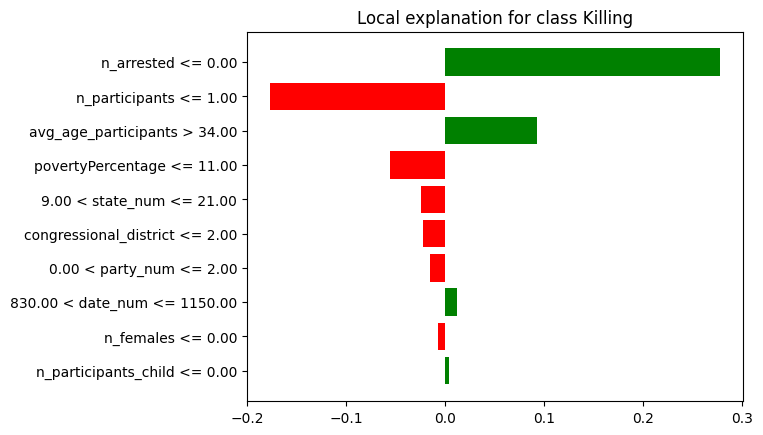

In [39]:
fig = explanation_1.as_pyplot_figure()
plt.show()

In [40]:
explain_lime(explanation_1,0,rd_fr)


Faithfulness:  0.2270462310075057
Monotonity:  False


In [41]:
instance_to_explain = X_test.iloc[4]
print("LABEL:",y_test.iloc[4])

explanation_0 = explainer_lime.explain_instance(instance_to_explain.values, rd_fr.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_0.show_in_notebook(show_table = True,predict_proba = True)



LABEL: 0
Intercept 0.3946699064900395
Prediction_local [0.60896788]
Right: 0.44003976497026115


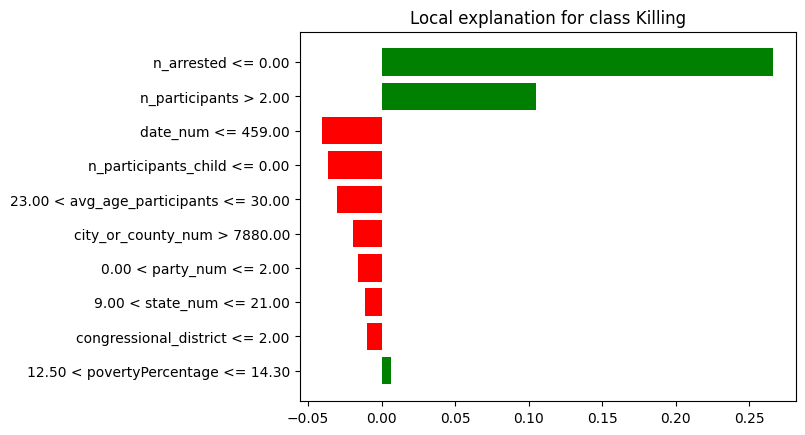

In [42]:
fig = explanation_0.as_pyplot_figure()
plt.show()

In [43]:
explain_lime(explanation_0,4,rd_fr)


Faithfulness:  -0.14807183620608266
Monotonity:  False


## SVM

In [44]:
import scikitplot as skplt


We run the prediction on our test set.

In [45]:

from sklearn.svm import SVC
svc = SVC(kernel = "rbf",random_state=42,C=10,gamma = "scale",probability=True)
svc.fit(X_trvl_undersample.values,y_trvl_undersample.values)


Explain LIME

In [ ]:
instance_to_explain = X_test.iloc[0]
predicted_class = svc.predict(X_test.values[0].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("LABEL:",y_test.iloc[0])

explanation_1 = explainer_lime.explain_instance(instance_to_explain.values, svc.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_1.show_in_notebook(show_table = True,predict_proba = True)


X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names


Predicted LABEL: [0]
LABEL: 0
Intercept 0.5000043975238114
Prediction_local [0.49998236]
Right: 0.5


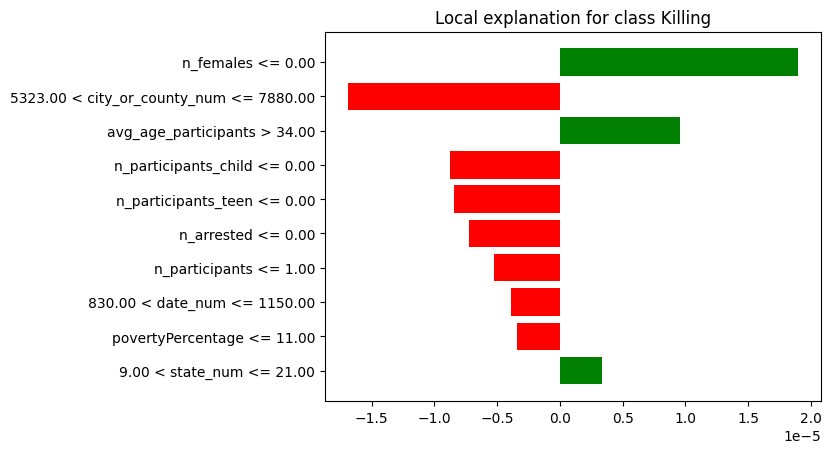

In [ ]:
fig = explanation_1.as_pyplot_figure()
plt.show()

In [ ]:
explain_lime(explanation_1,0,svc)

[1.000e+00 4.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.100e+01 8.940e+02 2.100e+01 6.103e+03 2.000e+00]
Faithfulness:  nan
Monotonity:  True


X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
invalid value encountered

In [ ]:
instance_to_explain = X_test.iloc[5]
predicted_class = svc.predict(X_test.values[5].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("LABEL:",y_test.iloc[5])

explanation_0 = explainer_lime.explain_instance(instance_to_explain.values, svc.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_0.show_in_notebook(show_table = True,predict_proba = True)


LABEL: 1


X does not have valid feature names, but SVC was fitted with feature names


Intercept 0.49998738346595517
Prediction_local [0.49999201]
Right: 0.5


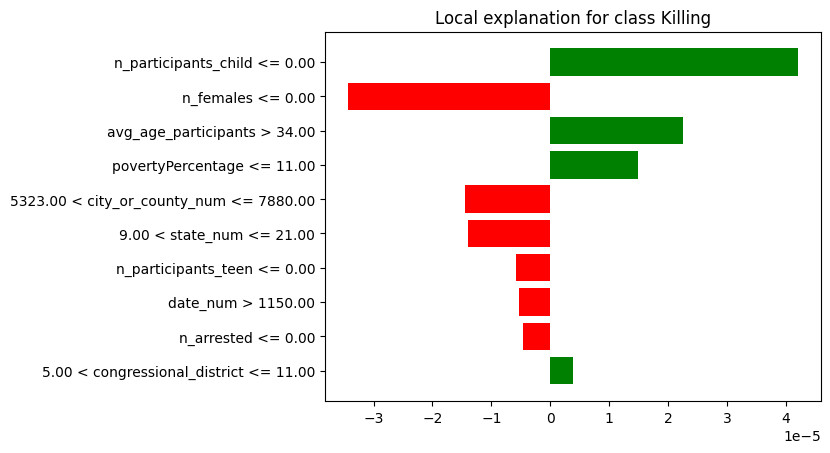

In [ ]:
fig = explanation_0.as_pyplot_figure()
plt.show()

In [ ]:
explain_lime(explanation_0,5,svc)


[7.000e+00 5.300e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e+00
 1.040e+01 1.208e+03 1.200e+01 6.201e+03 0.000e+00]
Faithfulness:  nan
Monotonity:  True


X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
invalid value encountered

# Neural network

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp = MLPClassifier(activation="tanh",hidden_layer_sizes=[12],solver="adam")
mlp.fit(X_trvl_undersample.values,y_trvl_undersample.values)

Explain lime

In [ ]:
instance_to_explain = X_test.iloc[0]
predicted_class = mlp.predict(X_test.values[0].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("LABEL:",y_test.iloc[0])

explanation_1 = explainer_lime.explain_instance(instance_to_explain.values, mlp.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_1.show_in_notebook(show_table = True,predict_proba = True)


In [ ]:
fig = explanation_1.as_pyplot_figure()
plt.show()

In [ ]:
instance_to_explain = X_test.iloc[5]
predicted_class = mlp.predict(X_test.values[5].reshape(1,-1))
print("Predicted LABEL:",predicted_class)
print("LABEL:",y_test.iloc[5])

explanation_0 = explainer_lime.explain_instance(instance_to_explain.values, mlp.predict_proba) #Lime does not support "predict",  LIME does not currently support classifier models without probability scores.

explanation_0.show_in_notebook(show_table = True,predict_proba = True)


In [ ]:
fig = explanation_0.as_pyplot_figure()
plt.show()